In [1]:
# PennyLane imports
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import GradientDescentOptimizer, AdamOptimizer, SPSAOptimizer
from pennylane.templates import BasicEntanglerLayers, StronglyEntanglingLayers

# General imports
import numpy as np

from qiskit.quantum_info import SparsePauliOp

import matplotlib.pyplot as plt

from scipy.optimize import differential_evolution

In [2]:
def create_matrix(cut_off, type):
    # Initialize a zero matrix of the specified size
    matrix = np.zeros((cut_off, cut_off), dtype=np.complex128)
    
    # Fill the off-diagonal values with square roots of integers
    for i in range(cut_off):
        if i > 0:  # Fill left off-diagonal
            if type == 'q':
                matrix[i][i - 1] = (1/np.sqrt(2)) * np.sqrt(i)  # sqrt(i) for left off-diagonal
            else:
                matrix[i][i - 1] = (1j/np.sqrt(2)) * np.sqrt(i)

        if i < cut_off - 1:  # Fill right off-diagonal
            if type == 'q':
                matrix[i][i + 1] = (1/np.sqrt(2)) * np.sqrt(i + 1)  # sqrt(i + 1) for right off-diagonal
            else:
                matrix[i][i + 1] = (-1j/np.sqrt(2)) * np.sqrt(i + 1)

    return matrix


# Function to calculate the Hamiltonian
def calculate_Hamiltonian(cut_off, potential):
    # Generate the position (q) and momentum (p) matrices
    q = create_matrix(cut_off, 'q')  # q matrix
    p = create_matrix(cut_off, 'p')  # p matrix

    # Calculate q^2 and q^3 for potential terms
    q2 = np.matmul(q, q)
    q3 = np.matmul(q2, q)

    #fermionic identity
    I_f = np.eye(2)

    #bosonic identity
    I_b = np.eye(cut_off)

    # Superpotential derivatives
    if potential == 'QHO':
        W_prime = q  # W'(q) = q
        W_double_prime = I_b #W''(q) = 1

    elif potential == 'AHO':
        W_prime = q + q3  # W'(q) = q + q^3
        W_double_prime = I_b + 3 * q2  # W''(q) = 1 + 3q^2

    elif potential == 'DW':
        W_prime = q + q2 + I_b  # W'(q) = q + q^2 + 1
        W_double_prime = I_b + 2 * q  # W''(q) = 1 + 2q

    else:
        print("Not a valid potential")
        raise

    # Kinetic term: p^2
    p2 = np.matmul(p, p)

    # Commutator term [b^†, b] = -Z
    Z = np.array([[1, 0], [0, -1]])  # Pauli Z matrix for fermion number
    commutator_term = np.kron(Z, W_double_prime)

    # Construct the block-diagonal kinetic term (bosonic and fermionic parts)
    # Bosonic part is the same for both, hence we use kron with the identity matrix
    kinetic_term = np.kron(I_f, p2)

    # Potential term (W' contribution)
    potential_term = np.kron(I_f, np.matmul(W_prime, W_prime))

    # Construct the full Hamiltonian
    H_SQM = 0.5 * (kinetic_term + potential_term + commutator_term)
    H_SQM[np.abs(H_SQM) < 10e-12] = 0
    
    return H_SQM

In [3]:
# Example usage for a 4x4 matrix
cut_off = 8
#potential = 'QHO'
potential = 'AHO'
H = calculate_Hamiltonian(cut_off, potential)
#Hamiltonian = qml.pauli_decompose(H)
hamiltonian = SparsePauliOp.from_operator(H)

num_qubits = hamiltonian.num_qubits

In [4]:
scale = 0.5
#params = scale*np.pi*pnp.random.randn(num_qubits, requires_grad=True)
params_shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=num_qubits)
params = scale*np.pi * pnp.random.random(size=params_shape)
params = scale * pnp.random.random(size=params_shape)

In [ ]:
# Device
#dev = qml.device('default.qubit', wires=num_qubits)
dev = qml.device('lightning.qubit', wires=num_qubits, shots=100)


cost_data = {'iters': 0}

# Define the cost function
@qml.qnode(dev)
def cost_function(params):
    params = pnp.tensor(params.reshape(params_shape), requires_grad=True)

    cost_data['iters'] +=1
    print(cost_data['iters'])

    #ry_cnot_ansatz(params)
    qml.StronglyEntanglingLayers(weights=params, wires=range(num_qubits), imprimitive=qml.CZ)
    return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))

In [8]:
# Define bounds for each parameter based on expected ranges (e.g., [0, 2π] for rotation angles)
bounds = [(0, 2 * np.pi) for _ in range(np.prod(params_shape))]

# Differential Evolution optimization
result = differential_evolution(cost_function, bounds, maxiter=100, strategy='best1bin', popsize=15)
params = result.x  # Extract optimized parameters
params = pnp.tensor(params.reshape(params_shape), requires_grad=True)

: 

In [169]:
result

             message: Optimization terminated successfully.
             success: True
                 fun: 0.019041328992114675
                   x: [ 5.371e+00  3.142e+00 ...  0.000e+00  4.434e+00]
                 nit: 98
                nfev: 22915
          population: [[ 5.371e+00  3.142e+00 ...  7.932e-04  4.434e+00]
                       [ 1.521e+00  3.146e+00 ...  8.532e-04  4.498e+00]
                       ...
                       [ 2.938e+00  3.144e+00 ...  3.240e-04  3.225e+00]
                       [ 2.721e+00  3.140e+00 ...  2.611e-03  3.584e+00]]
 population_energies: [ 1.904e-02  1.920e-02 ...  1.934e-02  1.916e-02]
                 jac: [-9.021e-09  2.184e-05 ...  6.002e-08 -1.908e-08]

In [139]:
from pyswarm import pso

In [152]:
n = np.prod(params_shape)
lb = [0] * n            
ub = [2 * np.pi] * n    

params, best_cost = pso(cost_function, lb, ub, swarmsize=50, maxiter=100)
params = pnp.tensor(params.reshape(params_shape), requires_grad=True)

Stopping search: Swarm best objective change less than 1e-08


In [179]:
stepsize = 0.5
optimizer = AdamOptimizer(stepsize=stepsize, beta1=0.99, beta2=0.999, eps=1e-8)

In [180]:
# Run the VQE optimization loop
max_iterations = 5000
convergence_tol = 1e-6
moving_avg_length = 5
gradient_tol = 1e-6

prev_energy = None
energies = []

moving_average_check = False
gradient_norm_check = False

for i in range(max_iterations):
    params, energy = optimizer.step_and_cost(cost_function, params)
    energies.append(energy)
    
    # Print the energy every few steps
    if i % 10 == 0:
        print(f"Iteration {i}: Energy = {energy}")

    # Moving average convergence check
    if len(energies) > moving_avg_length:
        energy_moving_avg = np.mean(np.abs(np.diff(energies[-moving_avg_length:])))
        if energy_moving_avg < convergence_tol:
            #print(f"Converged at iteration {i} with moving average change = {energy_moving_avg}")
            moving_average_check = True
            #converged = True
            #break

    # Gradient norm convergence check
    grads = optimizer.compute_grad(cost_function, (params,), {})
    grad_norm = np.linalg.norm(grads[0])
    if grad_norm < gradient_tol:
        #print(f"Converged at iteration {i} with gradient norm = {grad_norm}")
        gradient_norm_check = True

    if moving_average_check & gradient_norm_check:
        print("moving_average_check and gradient_norm_check converged")
        converged = True
        break

    # Check for convergence
    #if prev_energy is not None and np.abs(energy - prev_energy) < convergence_tol:
    #    print(f"Converged at iteration {i}")
    #    break

    prev_energy = energy

print("Final optimized energy:", energy)
print("Optimized parameters:", params)

Iteration 0: Energy = 65338.87449752087
Iteration 10: Energy = 9476.90105006129
Iteration 20: Energy = 6905.384728284646
Iteration 30: Energy = 1392.2787668233507
Iteration 40: Energy = 3971.346330557054
Iteration 50: Energy = 1390.5605696347388
Iteration 60: Energy = 2240.9760679976107
Iteration 70: Energy = 3260.7598500707572
Iteration 80: Energy = 436.539982090119
Iteration 90: Energy = 2719.0100223475492
Iteration 100: Energy = 1045.9119717586248
Iteration 110: Energy = 230.54909872155133
Iteration 120: Energy = 1879.040890313375
Iteration 130: Energy = 925.1118892078955
Iteration 140: Energy = 139.4121235964393
Iteration 150: Energy = 1339.4841018196694
Iteration 160: Energy = 719.661114280483
Iteration 170: Energy = 140.0843583440856
Iteration 180: Energy = 966.3809795884279
Iteration 190: Energy = 557.7560724719658
Iteration 200: Energy = 127.95715445432839
Iteration 210: Energy = 823.645140459146
Iteration 220: Energy = 213.23272624718604
Iteration 230: Energy = 375.76026802924

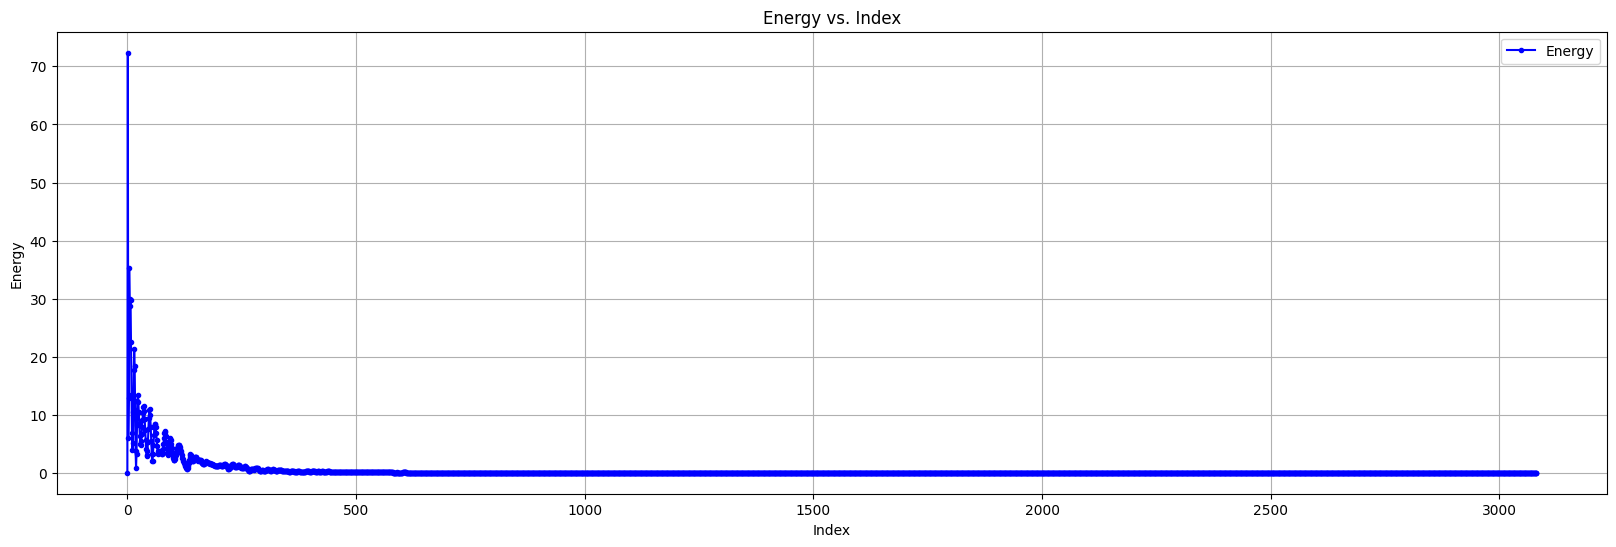

In [165]:
plt.figure(figsize=(20, 6))
plt.plot(energies, marker='.', linestyle='-', color='b', label="Energy")
plt.xlabel("Index")
plt.ylabel("Energy")
plt.title("Energy vs. Index")
plt.grid(True)
plt.legend()
plt.show()